<a href="https://colab.research.google.com/github/Foysal348/March-Machine-Learning-Mania-2026/blob/main/March_Machine_Learning_Mania_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1️⃣ DATA LOADING

In [31]:
import numpy as np
import pandas as pd
import itertools
import warnings
import xgboost as xgb
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.metrics import brier_score_loss
from scipy.interpolate import UnivariateSpline

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 999)

data_dir = "/content/drive/MyDrive/CSV file"

M_regular = pd.read_csv(f"{data_dir}/MRegularSeasonDetailedResults.csv")
M_tourney = pd.read_csv(f"{data_dir}/MNCAATourneyDetailedResults.csv")
M_seeds   = pd.read_csv(f"{data_dir}/MNCAATourneySeeds.csv")

W_regular = pd.read_csv(f"{data_dir}/WRegularSeasonDetailedResults.csv")
W_tourney = pd.read_csv(f"{data_dir}/WNCAATourneyDetailedResults.csv")
W_seeds   = pd.read_csv(f"{data_dir}/WNCAATourneySeeds.csv")

regular_results = pd.concat([M_regular, W_regular])
tourney_results = pd.concat([M_tourney, W_tourney])
seeds = pd.concat([M_seeds, W_seeds])

season_cutoff = 2003
regular_results = regular_results[regular_results["Season"] >= season_cutoff]
tourney_results = tourney_results[tourney_results["Season"] >= season_cutoff]
seeds = seeds[seeds["Season"] >= season_cutoff]



# 2️⃣ PREPARE DATA

In [ ]:
def prepare_data(df):

    df = df[[
        "Season","DayNum","LTeamID","LScore","WTeamID","WScore","NumOT",
        "LFGM","LFGA","LFGM3","LFGA3","LFTM","LFTA","LOR","LDR","LAst","LTO","LStl","LBlk","LPF",
        "WFGM","WFGA","WFGM3","WFGA3","WFTM","WFTA","WOR","WDR","WAst","WTO","WStl","WBlk","WPF"
    ]]

    adjot = (40 + 5*df["NumOT"]) / 40
    for col in df.columns[3:]:
        df[col] = df[col] / adjot

    dfswap = df.copy()

    df.columns = [c.replace("W","T1_").replace("L","T2_") for c in df.columns]
    dfswap.columns = [c.replace("L","T1_").replace("W","T2_") for c in dfswap.columns]

    out = pd.concat([df, dfswap]).reset_index(drop=True)
    out["PointDiff"] = out["T1_Score"] - out["T2_Score"]
    out["win"] = (out["PointDiff"] > 0).astype(int)
    out["men_women"] = (out["T1_TeamID"].astype(str).str.startswith("1")).astype(int)

    return out

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)



# 3️⃣ SEED FEATURES

In [ ]:

seeds["seed"] = seeds["Seed"].str[1:3].astype(int)

seeds_T1 = seeds.rename(columns={"TeamID":"T1_TeamID","seed":"T1_seed"})[["Season","T1_TeamID","T1_seed"]]
seeds_T2 = seeds.rename(columns={"TeamID":"T2_TeamID","seed":"T2_seed"})[["Season","T2_TeamID","T2_seed"]]

tourney_data = tourney_data[["Season","T1_TeamID","T2_TeamID","PointDiff","win","men_women"]]

tourney_data = tourney_data.merge(seeds_T1,on=["Season","T1_TeamID"],how="left")
tourney_data = tourney_data.merge(seeds_T2,on=["Season","T2_TeamID"],how="left")

tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]

# 4️⃣ SEASON AVERAGE FEATURES

In [ ]:
boxcols = [c for c in regular_data.columns if c.startswith("T1_") or c.startswith("T2_")]
boxcols = [c for c in boxcols if "TeamID" not in c]

ss = regular_data.groupby(["Season","T1_TeamID"])[boxcols+["PointDiff"]].mean().reset_index()

ss_T1 = ss.copy()
ss_T1.columns = ["Season","T1_TeamID"] + ["T1_avg_"+c for c in ss.columns[2:]]

ss_T2 = ss.copy()
ss_T2.columns = ["Season","T2_TeamID"] + ["T2_avg_"+c for c in ss.columns[2:]]

tourney_data = tourney_data.merge(ss_T1,on=["Season","T1_TeamID"],how="left")
tourney_data = tourney_data.merge(ss_T2,on=["Season","T2_TeamID"],how="left")


# 5️⃣ ELO RATING

In [32]:
def expected_result(a,b):
    return 1/(1+10**((b-a)/400))

def update_elo(w,l,k=100):
    exp = expected_result(w,l)
    change = k*(1-exp)
    return w+change, l-change

elos=[]

for season in sorted(regular_data["Season"].unique()):

    df=regular_data[(regular_data["Season"]==season)&(regular_data["win"]==1)]
    teams=set(df["T1_TeamID"])|set(df["T2_TeamID"])
    elo={t:1000 for t in teams}

    for _,row in df.iterrows():
        w,l=row["T1_TeamID"],row["T2_TeamID"]
        elo[w],elo[l]=update_elo(elo[w],elo[l])

    temp=pd.DataFrame({"TeamID":elo.keys(),"elo":elo.values()})
    temp["Season"]=season
    elos.append(temp)

elos=pd.concat(elos)

elos_T1=elos.rename(columns={"TeamID":"T1_TeamID","elo":"T1_elo"})
elos_T2=elos.rename(columns={"TeamID":"T2_TeamID","elo":"T2_elo"})

tourney_data=tourney_data.merge(elos_T1,on=["Season","T1_TeamID"],how="left")
tourney_data=tourney_data.merge(elos_T2,on=["Season","T2_TeamID"],how="left")

tourney_data["elo_diff"]=tourney_data["T1_elo"]-tourney_data["T2_elo"]

# 6️⃣ GLM TEAM QUALITY

In [33]:
from sklearn.linear_model import Ridge

glm_quality=[]

for season in tqdm(sorted(regular_data["Season"].unique())):

    dt=regular_data[regular_data["Season"]==season].copy()

    teams = pd.concat([dt["T1_TeamID"],dt["T2_TeamID"]]).unique()
    team_index = {t:i for i,t in enumerate(teams)}

    n=len(dt)
    m=len(teams)

    X=np.zeros((n,m))

    for i,row in enumerate(dt.itertuples()):
        X[i,team_index[row.T1_TeamID]]=1
        X[i,team_index[row.T2_TeamID]]=-1

    y=dt["PointDiff"].values

    model=Ridge(alpha=1.0,fit_intercept=False)
    model.fit(X,y)

    coef=model.coef_

    q=pd.DataFrame({
        "Season":season,
        "TeamID":teams,
        "quality":coef
    })

    glm_quality.append(q)

glm_quality=pd.concat(glm_quality)



100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


In [34]:
# CREATE glm_T1 & glm_T2 (REQUIRED FOR STEP 9
glm_T1 = glm_quality.rename(
    columns={"TeamID": "T1_TeamID", "quality": "T1_quality"}
)

glm_T2 = glm_quality.rename(
    columns={"TeamID": "T2_TeamID", "quality": "T2_quality"}
)

# 7️⃣ MODEL TRAINING

In [35]:
from sklearn.model_selection import KFold

features = [c for c in tourney_data.columns if c not in
            ["Season","PointDiff","win","T1_TeamID","T2_TeamID"]]

param = {
    "objective": "reg:squarederror",
    "eta": 0.03,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "nthread": -1
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = []
oof_preds = np.zeros(len(tourney_data))
oof_targets = tourney_data["PointDiff"].values

for fold, (tr_idx, val_idx) in enumerate(kf.split(tourney_data)):

    print("Training fold:", fold+1)

    train = tourney_data.iloc[tr_idx]
    val   = tourney_data.iloc[val_idx]

    dtrain = xgb.DMatrix(
        train[features],
        label=train["PointDiff"],
        feature_names=features
    )

    dval = xgb.DMatrix(
        val[features],
        label=val["PointDiff"],
        feature_names=features
    )

    model = xgb.train(
        param,
        dtrain,
        num_boost_round=2000,
        evals=[(dval, "val")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    models.append(model)

    oof_preds[val_idx] = model.predict(dval)

print("Step 7 finished.")

Training fold: 1
Training fold: 2
Training fold: 3
Training fold: 4
Training fold: 5
Step 7 finished.



# 8️⃣ SPLINE CALIBRATION

In [36]:
t=25
dat=sorted(zip(oof_preds,np.array(oof_targets)>0),key=lambda x:x[0])
pred,label=zip(*dat)

spline_model=UnivariateSpline(np.clip(pred,-t,t),label,k=5)

oof_probs=np.clip(spline_model(np.clip(oof_preds,-t,t)),0.01,0.99)
print("OOF Brier:",brier_score_loss(np.array(oof_targets)>0,oof_probs))





OOF Brier: 0.16879514458308953


# 9️⃣ LOAD MATCHUPS FROM SAMPLE SUBMISSION

In [37]:
sample = pd.read_csv(f"{data_dir}/SampleSubmissionStage1.csv")

print("Sample shape:", sample.shape)   # should be (519144, 2)

# Split ID
sample[["Season","T1_TeamID","T2_TeamID"]] = (
    sample["ID"].str.split("_", expand=True)
)

sample["Season"] = sample["Season"].astype(int)
sample["T1_TeamID"] = sample["T1_TeamID"].astype(int)
sample["T2_TeamID"] = sample["T2_TeamID"].astype(int)

X = sample.copy()

# men_women feature
X["men_women"] = (
    X["T1_TeamID"].astype(str).str.startswith("1")
).astype(int)

# MERGE FEATURES

X = X.merge(ss_T1,on=["Season","T1_TeamID"],how="left")
X = X.merge(ss_T2,on=["Season","T2_TeamID"],how="left")
X = X.merge(seeds_T1,on=["Season","T1_TeamID"],how="left")
X = X.merge(seeds_T2,on=["Season","T2_TeamID"],how="left")
X = X.merge(glm_T1,on=["Season","T1_TeamID"],how="left")
X = X.merge(glm_T2,on=["Season","T2_TeamID"],how="left")
X = X.merge(elos_T1,on=["Season","T1_TeamID"],how="left")
X = X.merge(elos_T2,on=["Season","T2_TeamID"],how="left")

# Derived features
X["Seed_diff"] = X["T2_seed"] - X["T1_seed"]
X["elo_diff"] = X["T1_elo"] - X["T2_elo"]
X["diff_quality"] = X["T1_quality"] - X["T2_quality"]

Sample shape: (519144, 2)


# 🔟 PREDICT

In [38]:
dtest = xgb.DMatrix(
    X[features],
    feature_names=features
)

preds = []

for model in models:

    margin = model.predict(dtest)

    probs = np.clip(
        spline_model(np.clip(margin, -25, 25)),
        0.01, 0.99
    )

    preds.append(probs)

X["Pred"] = np.mean(preds, axis=0)

print("Prediction completed.")

Prediction completed.


# 1️⃣1️⃣ CREATE SUBMISSION

In [39]:
submission = X[["ID","Pred"]].copy()
submission["Pred"] = submission["Pred"].round(6)

submission.to_csv("submission.csv", index=False)

print("submission.csv created successfully")
print(submission.shape)   # MUST be (519144, 2)


submission.csv created successfully
(519144, 2)


# 1️⃣2️⃣ Model Performance Check

In [40]:
## 1️⃣  SUBMISSION Related
print(submission["Pred"].min(), submission["Pred"].max())
print(submission.isna().sum().sum())
print(submission["ID"].duplicated().sum())

0.011577 0.989535
0
0


In [41]:
# Convert to numpy arrays first
oof_targets = np.array(oof_targets)
oof_preds   = np.array(oof_preds)

# Margin → probability
oof_probs = np.clip(
    spline_model(np.clip(oof_preds, -25, 25)),
    0.01, 0.99
)

# Binary target
y_binary = (oof_targets > 0).astype(int)

baseline = np.mean((0.5 - y_binary)**2)
model_score = np.mean((oof_probs - y_binary)**2)

print("Baseline Brier:", round(baseline,6))
print("Model Brier:", round(model_score,6))
print("Improvement:", round(baseline - model_score,6))

Baseline Brier: 0.25
Model Brier: 0.168795
Improvement: 0.081205


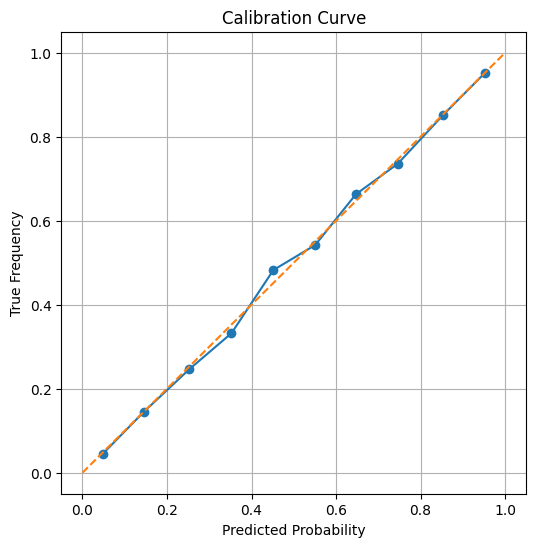

In [42]:
# 2️⃣ CALIBRATION CURVE

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# numpy
oof_targets = np.array(oof_targets)
oof_preds   = np.array(oof_preds)

# margin → probability
oof_probs = np.clip(
    spline_model(np.clip(oof_preds, -25, 25)),
    0.01, 0.99
)

# binary label
y_binary = (oof_targets > 0).astype(int)

prob_true, prob_pred = calibration_curve(
    y_binary,
    oof_probs,
    n_bins=10
)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.title("Calibration Curve")
plt.grid(True)
plt.show()

In [43]:
# SAFE FEATURE IMPORTANCE
import pandas as pd
import numpy as np

importance_dict = {}

valid_models = [m for m in models if hasattr(m, "get_score")]

for m in valid_models:

    score = m.get_score(importance_type="gain")

    for k, v in score.items():
        importance_dict[k] = importance_dict.get(k, 0) + v

if len(importance_dict) == 0:
    print("No valid XGBoost models found.")
else:
    imp = pd.DataFrame({
        "Feature": list(importance_dict.keys()),
        "Importance": list(importance_dict.values())
    }).sort_values("Importance", ascending=False)

    print(imp.head(30))

             Feature     Importance
3          Seed_diff  169981.453125
2            T2_seed   81571.909180
1            T1_seed   59412.611328
64          elo_diff   48967.792969
32  T1_avg_PointDiff   36730.110840
61  T2_avg_PointDiff   35951.357910
62            T1_elo   31598.806641
0          men_women   28560.806152
19     T1_avg_T1_FGM   16901.324951
48     T2_avg_T1_FGM   14410.839233
27     T1_avg_T1_Ast   12562.241455
63            T2_elo   12427.258179
56     T2_avg_T1_Ast   10704.814087
20     T1_avg_T1_FGA    9721.895874
49     T2_avg_T1_FGA    9662.473633
31      T1_avg_T1_PF    9307.503052
34   T2_avg_T1_Score    8484.067993
5    T1_avg_T1_Score    8211.866943
33   T2_avg_T2_Score    8170.277710
40     T2_avg_T2_FTA    7927.064209
60      T2_avg_T1_PF    7732.072998
13      T1_avg_T2_DR    7633.500366
10     T1_avg_T2_FTM    7600.467041
59     T2_avg_T1_Blk    7594.231567
11     T1_avg_T2_FTA    7590.860596
42      T2_avg_T2_DR    7405.968750
28      T1_avg_T1_TO    7319

In [44]:
imp["pct"] = imp["Importance"] / imp["Importance"].sum()

print(imp.head(10))
print("\nTop feature dominance:", imp["pct"].iloc[0])

             Feature     Importance       pct
3          Seed_diff  169981.453125  0.185924
2            T2_seed   81571.909180  0.089223
1            T1_seed   59412.611328  0.064985
64          elo_diff   48967.792969  0.053561
32  T1_avg_PointDiff   36730.110840  0.040175
61  T2_avg_PointDiff   35951.357910  0.039323
62            T1_elo   31598.806641  0.034563
0          men_women   28560.806152  0.031240
19     T1_avg_T1_FGM   16901.324951  0.018487
48     T2_avg_T1_FGM   14410.839233  0.015762

Top feature dominance: 0.18592429828124069


In [45]:
imp[imp["Feature"].str.contains("TeamID|Season")]

,Feature,Importance,pct


In [46]:
imp["family"] = imp["Feature"].str.extract(
    "(seed|elo|quality|avg)"
)

print(
    imp.groupby("family")["Importance"].sum()
        .sort_values(ascending=False)
)

family
avg     481730.241394
seed    140984.520508
elo      92993.857788
Name: Importance, dtype: float64


In [47]:
print(imp.head(5))

             Feature     Importance       pct family
3          Seed_diff  169981.453125  0.185924    NaN
2            T2_seed   81571.909180  0.089223   seed
1            T1_seed   59412.611328  0.064985   seed
64          elo_diff   48967.792969  0.053561    elo
32  T1_avg_PointDiff   36730.110840  0.040175    avg


In [48]:
tourney_data["noise_test"] = np.random.rand(len(tourney_data))

In [49]:
imp[imp["Feature"]=="noise_test"]

,Feature,Importance,pct,family


In [50]:
sample = pd.read_csv(f"{data_dir}/SampleSubmissionStage2.csv")
print(sample.shape)

(132133, 2)


In [51]:
sample = pd.read_csv(f"{data_dir}/SampleSubmissionStage1.csv")
print(sample.shape)

(519144, 2)


In [52]:
from google.colab import files

files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>